In [2]:
import numpy as np
import sympy as sym
import hjson
from pydae.bmapu.bmapu_builder import bmapu
import pydae.build_v2 as db
import pytest
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
grid = bmapu('milano4ord.hjson')
grid.checker()
grid.uz_jacs = True
grid.construct('temp')

fault_b = sym.Symbol('fault_b_1', real=True)
fault_g = sym.Symbol('fault_g_1', real=True)
fault_g_ref= sym.Symbol('fault_g_ref_1', real=True)
RampDown = sym.Symbol('RampDown_1', real=True)
RampUp = sym.Symbol('RampUp_1', real=True)
K_fault = sym.Symbol('K_fault_1', real=True)

V = sym.Symbol('V_1', real=True)


epsilon_g = fault_g_ref - fault_g
dfault_g_nosat = K_fault*(fault_g_ref - fault_g)
dfault_g_sat = sym.Piecewise((RampDown,dfault_g_nosat<RampDown),
                             (RampUp,dfault_g_nosat>RampUp),
                             (dfault_g_nosat,True))
grid.dae['f'] += [dfault_g_sat]
grid.dae['x'] += [fault_g]

grid.dae['g'][1] += fault_g*V**2
grid.dae['g'][1] += fault_b*V**2

grid.dae['u_ini_dict'].update({f'{fault_b}':0.0})
grid.dae['u_run_dict'].update({f'{fault_b}':0.0})
grid.dae['u_ini_dict'].update({f'{fault_g_ref}':0.0})
grid.dae['u_run_dict'].update({f'{fault_g_ref}':0.0})

grid.dae['params_dict'].update({f'{str(RampDown)}':-20000})
grid.dae['params_dict'].update({f'{str(RampUp)}':10000})
grid.dae['params_dict'].update({f'{str(K_fault)}':10000})


grid.compile()

One generator must have K_delta > 0.0


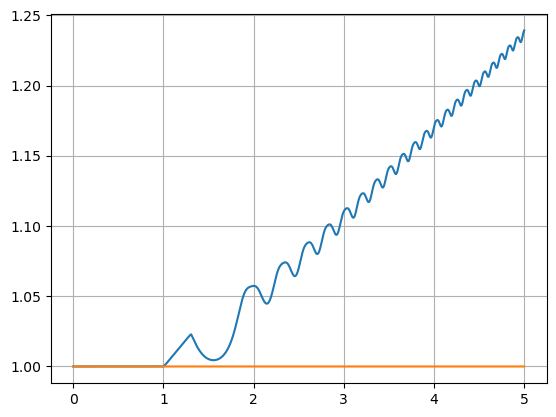

In [3]:

import temp

model = temp.model()
model.Dt = 0.001
model.decimation = 1

v_ref_1 = 1.0
model.ini({'p_m_1':0.8,'v_ref_1':v_ref_1,'K_a_1':50, 'R_a_1':0.00, 'V_f_max_1':5.00, 'V_f_min_1':-5.00,
           'RampDown_1':-45e3,'RampUp_1':30e3, 'K_fault_1':20e2},'xy_0.json')

# assert model.get_value('V_1') == pytest.approx(v_ref_1, rel=0.001)

model.run(1.0,{})
model.run(1.24,{'fault_g_ref_1':3000})
model.run(5,{'fault_g_ref_1':0})

# model.run(1.11,{'fault_g_ref_1':0})
# model.run(2,{'fault_g_ref_1':0})

model.post()
# # assert model.get_value('q_A2') == pytest.approx(-q_ref, rel=0.05)

# model.ini({'p_m_1':0.5,'v_ref_1':1.0},'xy_0.json')
# model.run(1.0,{})
# model.run(15.0,{'v_ref_1':1.05})
# model.post()


fig,axes = plt.subplots()
axes.plot(model.Time,model.get_values('omega_1'))
axes.plot(model.Time,model.get_values('omega_coi'))
#axes.plot(model.Time,model.Y)
axes.grid()
fig.savefig('milano4ord_fault.svg')


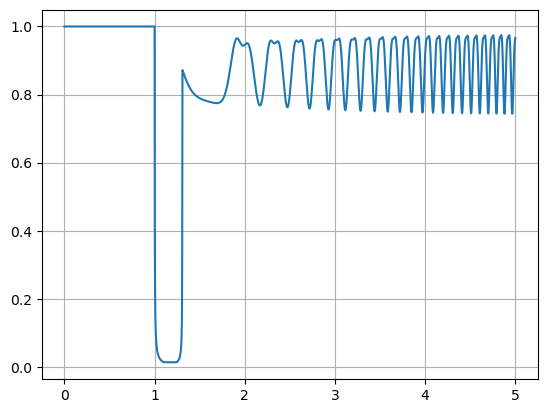

In [4]:

fig,axes = plt.subplots()
axes.plot(model.Time,model.get_values('V_1'))
#axes.plot(model.Time,model.Y)
axes.grid()


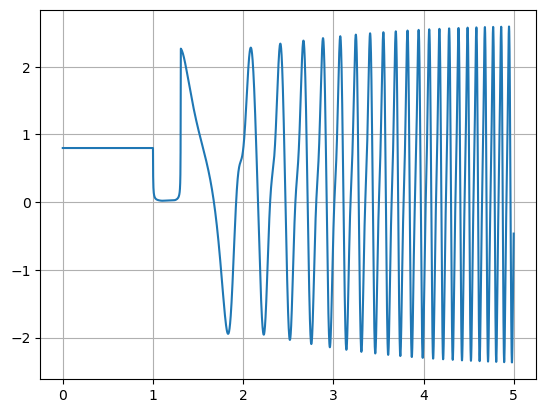

In [5]:
fig,axes = plt.subplots()
axes.plot(model.Time,model.get_values('p_g_1'))
#axes.plot(model.Time,model.Y)
axes.grid()

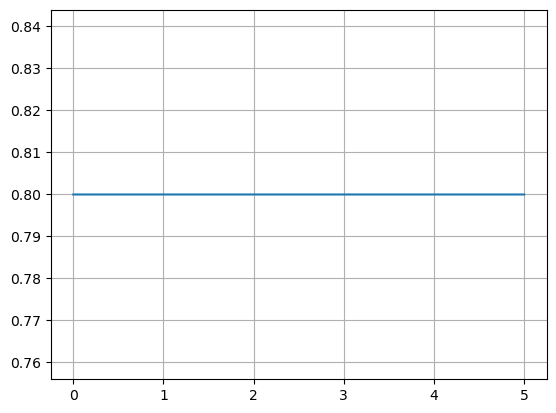

In [6]:
fig,axes = plt.subplots()
axes.plot(model.Time,model.get_values('p_m_1'))
#axes.plot(model.Time,model.Y)
axes.grid()

In [9]:
model.report_params()

S_base =100000000.00
g_1_2 = 7.69
b_1_2 =-38.46
bs_1_2 = 0.00
g_shunt_1 = 0.00
b_shunt_1 =-0.00
U_1_n =20000.00
U_2_n =20000.00
Omega_b_1 =314.16
S_n_1 =200000000.00
H_1   = 5.00
T1d0_1 = 8.00
T1q0_1 = 0.40
X_d_1 = 1.80
X_q_1 = 1.70
X1d_1 = 0.30
X1q_1 = 0.55
D_1   = 0.00
R_a_1 = 0.00
K_delta_1 = 0.00
K_sec_1 = 0.00
K_sat_1 = 1.00
K_a_1 =50.00
K_ai_1 = 0.00
T_r_1 = 0.10
T_c_1 = 1.00
T_b_1 = 1.00
V_f_max_1 = 5.00
V_f_min_1 =-5.00
K_p_agc = 0.00
K_i_agc = 0.00
K_xif = 0.01
RampDown_1 =-45000.00
RampUp_1 =30000.00
K_fault_1 =2000.00


In [5]:
import temp

model = temp.model()
model.Dt = 0.001
model.decimation = 1

v_ref_1 = 1.0
model.ini({'p_m_1':0.85,'v_ref_1':v_ref_1,'K_a_1':50, 'R_a_1':0.00, 
           'V_f_max_1':5.00, 'V_f_min_1':-5.00,
           'RampDown_1':-45e3,'RampUp_1':30e3, 'K_fault_1':20e2},'xy_0.json')

# assert model.get_value('V_1') == pytest.approx(v_ref_1, rel=0.001)

g_ref = -10000
model.run(1.0,{})
t_clear = 1.26
model.run(t_clear,{'g_shunt_1':g_ref})
model.Dt = 1e-4
tf = t_clear
for it in range(5000):
    model.run(tf,{'g_shunt_1':g_ref})
    g_ref = g_ref/1.05
    tf = tf+model.Dt
    if np.abs(g_ref)<0.001: break
model.Dt = 1e-3
# model.run(t_clear1,{'fault_g_ref_1':0})
model.run(3.5,{'g_shunt_1':g_ref})
model.post()

In [6]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=model.Time, y=model.get_values('omega_1'), mode='lines', name='omega_1'))

fig.update_layout(
    title='Short Circuit',
    xaxis_title='Time (s)',
    yaxis_title='Currents',
    hovermode='closest'
)

fig.show()

In [ ]:
t_fault = 1.1
g_ref = -5000
model.run(1.0,{})
model.run(t_fault,{'g_shunt_1':g_ref})

model.Dt = 1e-5
tf = t_fault + model.Dt 
for it in range(500):
    print(tf,g_ref)
    model.run(tf,{'g_shunt_1':g_ref})
    g_ref = g_ref/1.2
    tf = tf+model.Dt
    if np.abs(g_ref)<0.0001: break
model.Dt = 1e-3
model.run(2.0,{'g_shunt_1':g_ref})

model.post()

In [7]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=model.Time, y=model.get_values('V_1'), mode='lines', name='V_1'))

fig.update_layout(
    title='Short Circuit',
    xaxis_title='Time (s)',
    yaxis_title='Currents',
    hovermode='closest'
)

fig.show()

In [8]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=model.get_values('delta_1'), y=model.get_values('p_g_1'), mode='lines', name='p_g_1'))
fig.add_trace(go.Scatter(x=model.get_values('delta_1'), y=model.get_values('p_m_1'), mode='lines', name='p_m_1'))

fig.update_layout(
    title='Short Circuit',
    xaxis_title='Time (s)',
    yaxis_title='Currents',
    hovermode='closest'
)

fig.show()